# Demonstration of CG building of linear polymer chains

In [1]:
# logging tools
import logging
logging.basicConfig(
    level=logging.WARNING,
    # level=logging.DEBUG,
    force=True,
)

from rich.progress import Progress, BarColumn, TimeRemainingColumn
def build_progress() -> Progress:
    return Progress(
        "[progress.description]{task.description}",
        BarColumn(),
        "(polymer {task.completed}/{task.total})",
        TimeRemainingColumn(),
        "Placing {task.fields[chain_len]}-mer chain",
        auto_refresh=False,
    )

# library imports
import numpy as np

from mupt.geometry.shapes import Ellipsoid, Sphere
from mupt.geometry.coordinates.reference import CoordAxis, origin
from mupt.geometry.transforms.rigid import rigid_vector_coalignment

from mupt.mupr.primitives import Primitive
from mupt.mupr.connection import TraversalDirection

from mupt.interfaces.rdkit import primitive_to_rdkit, suppress_rdkit_logs
from mupt.interfaces.smiles import primitive_from_smiles

## Compile lexicon of unit repeat units (with fitted encompassing shapes)
Here we specify all distinct, unique chemical fragments as they appear within a polymer chain (imagine "cutting" up a complete chain into its repeat units)  
Each fragment is defined by a SMILES string, with two "edge" atoms marked out by map numbers indicating the head/tail direction that repeat unit should face within a chain  

These marked sites will also be used to fit an encompassing rigid "shape" (Sphere or Ellipsoid in this demo) over the atomic conformer for each fragment;  
In the future, this relationship will be inverted, i.e. first setting the bead size, then relaxing the atomic conformer to fit the body
This shape is useful for a coarse-grained representation of the system (e.g. Kremer-Grest beads) which remains synchronized during backmap

In [2]:
AXIS : CoordAxis = CoordAxis.X
SEMIMINOR_FRACT : float = 0.5 # how long the pair of minor axes should be as a fraction of the major axis length

# N.B.: atom map numbers here are semantically meaningful an encode chain directionality
# "1" points forward ("ANTERO") along the chain, while "2" points backward ("RETRO");
# site with opposite direction are designated compatible for chain bonds, while those with matching direction are not
rep_unit_smiles : dict[str, str] = {
    'head' : f'[H]-[O:1]c1ccc(cc1)S(=O)(=O)c1cc[c:2](cc1)-*',
    'mid'  : f'*-[O:1]c1ccc(cc1)S(=O)(=O)c1cc[c:2](cc1)-*',
    'tail' : f'*-[O:1]c1ccc(cc1)S(=O)(=O)c1ccc(cc1)[O:2]-[H]',
}

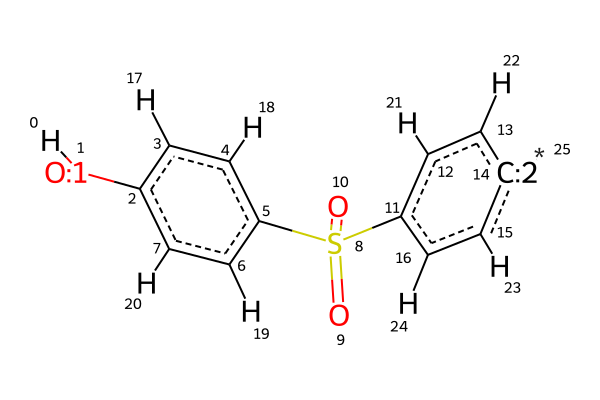

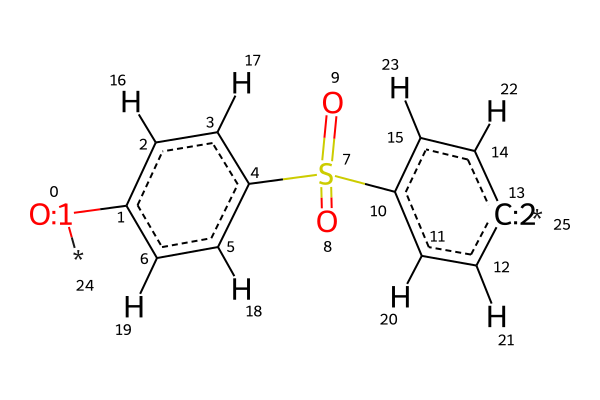

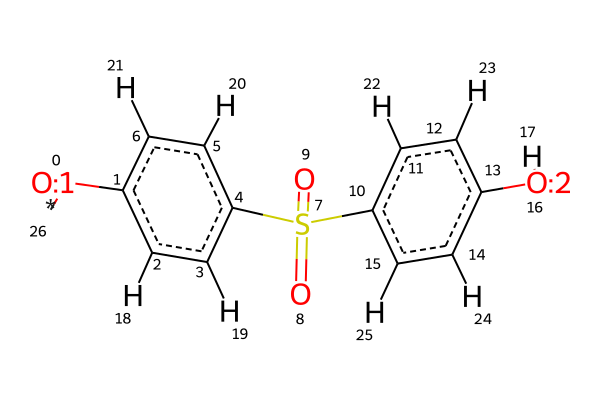

In [3]:
lexicon : dict[str, Primitive] = {}
with suppress_rdkit_logs():
    for unit_name, smiles in rep_unit_smiles.items():
        unitprim = primitive_from_smiles(smiles, ensure_explicit_Hs=True, embed_positions=True, label=unit_name)
            
        # force edge atoms to lie along chosen axis, with midpoint at the origin
        head_atom, tail_atom = unitprim.search_hierarchy_by(lambda prim : 'molAtomMapNumber' in prim.metadata, min_count=2)
        head_pos, tail_pos = head_atom.shape.centroid, tail_atom.shape.centroid
        
        major_radius = np.linalg.norm(tail_pos - head_pos) / 2.0
        axis_vec = np.zeros(3, dtype=float)
        axis_vec[AXIS.value] = major_radius
        axis_alignment = rigid_vector_coalignment(
            vector1_start=head_pos,
            vector1_end=tail_pos,
            vector2_start=origin(3),
            vector2_end=axis_vec,
            t1=1/2,
            t2=0.0,
        )
        unitprim.rigidly_transform(axis_alignment)
        lexicon[unit_name] = unitprim
        
        # set enveloping body around repeat unit - not necessary for backmap, but allows sphere placement for e.g. Kremer-Grest models
        semiminor = SEMIMINOR_FRACT * major_radius
        radii = np.full(3, semiminor)
        radii[AXIS.value] = major_radius
        unitprim.shape = Ellipsoid(radii) # = Sphere(major_radius)
        
        # show RDKit depction of aligned repeat unit
        rdmol = primitive_to_rdkit(unitprim)
        display(rdmol)

## Construct hierarchy of Primitives representing polymer system
Hierarchy constructed here corresponds to abox of homopolymer chains with a given distribution of lengths;  
any given branch traced through the hierarchy is structured as Universe -> chains -> repeat units -> atoms

Each chain's units begin in reference position (i.e. level and centered at origin) initially, and are then placed by a placement generator  
An angle-constrained random walk is provided as an example implementation, but other implementations (e.g. DPD) can be slotted in just as easily by replacing the kind of builder user

In [4]:
# configure system parameters
R_excl : float = 10.0
bond_length : float = 1.5 # 5.5
angle_max_rad : float = np.pi/4

n_chains : int = 4
dop_min : int = 10 # must be at least 2!
dop_max : int = 15

Output()

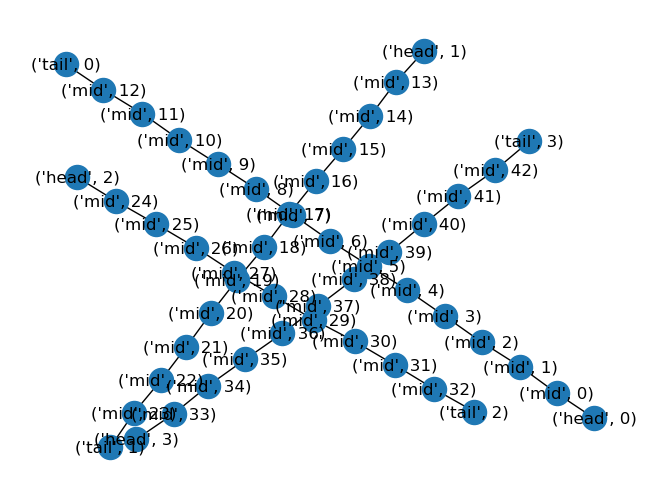

In [5]:
import networkx as nx
from mupt.mupr.topology import TopologicalStructure

from mupt.builders.random_walk import AngleConstrainedRandomWalk
from mupt.geometry.coordinates.directions import random_unit_vector


univprim = Primitive(label='universe')
with build_progress() as progress:
    task = progress.add_task('Building chains', total=n_chains, chain_len=0)
    for chain_len in np.random.randint(dop_min, dop_max + 1, size=n_chains):
        progress.update(task, chain_len=chain_len)
        
        # build chain hierarchy
        molprim = Primitive(label=f'{chain_len}-mer_chain')
        unit_names : list[str] = ['head'] + ['mid']*(chain_len - 2) + ['tail']
        for i, unit_name in enumerate(unit_names)   :
            rep_unit_prim = lexicon[unit_name].copy()
            molprim.attach_child(rep_unit_prim)
            
        # assign path graph as topology, connecting adjacent Primitives
        molprim.set_topology(
            nx.path_graph(
                molprim.children_by_handle.keys(),
                create_using=TopologicalStructure,
            ),
            max_registration_iter=100,
        )

        # place beads by random walk (other build implementations would go here)
        direction = random_unit_vector()
        builder = AngleConstrainedRandomWalk(
            bond_length=bond_length,
            angle_max_rad=angle_max_rad,
            initial_point=R_excl*direction,
            initial_direction=direction,  # randomize starting direction to reduce likelihood of collisions
        )
        for handle, placement in builder.generate_placements(molprim):
            molprim.children_by_handle[handle].rigidly_transform(placement)
            
        # attach chain to universe, expand to show topology of beads
        mol_handle = univprim.attach_child(molprim)
        univprim.expand(mol_handle)
        
        progress.advance(task)
        progress.refresh()

univprim.visualize_topology()

## Flatten Primitive hierarchy and export as all-atom system
Expand each level until the hierarchy is just leaves below a root (atoms in a molecule system), then write out to RDKit

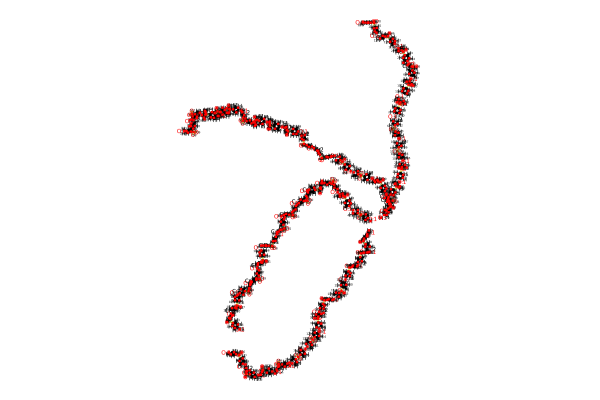

In [6]:
from mupt.interfaces.rdkit import primitive_to_rdkit

univmol = primitive_to_rdkit(univprim.copy()) # make copy for export, as flattening is done in-place
display(univmol)

In [7]:
from pathlib import Path
from rdkit.Chem import SDWriter


save_dir : Path = Path('mupt-built_systems')
save_dir.mkdir(exist_ok=True)
save_path : Path = save_dir / f'ellipsoidal_backmap_{n_chains}x[{dop_min}-{dop_max}]-mer_chains.sdf'

with SDWriter(str(save_path)) as sdf_writer:
    sdf_writer.write(univmol) # DEV: write individual chains, with respective metadata one-at-a-time?
print(f'Exported {univmol.GetNumAtoms()}-atom system to {save_path}')

Exported 1236-atom system to mupt-built_systems/ellipsoidal_backmap_4x[10-15]-mer_chains.sdf


## Visualize placement of subprimitives [slow for larger systems, can skip if desired]
Visualize co-levels in hierarchy and plot residues (as Ellipsoids here) and individual atoms (as single points)

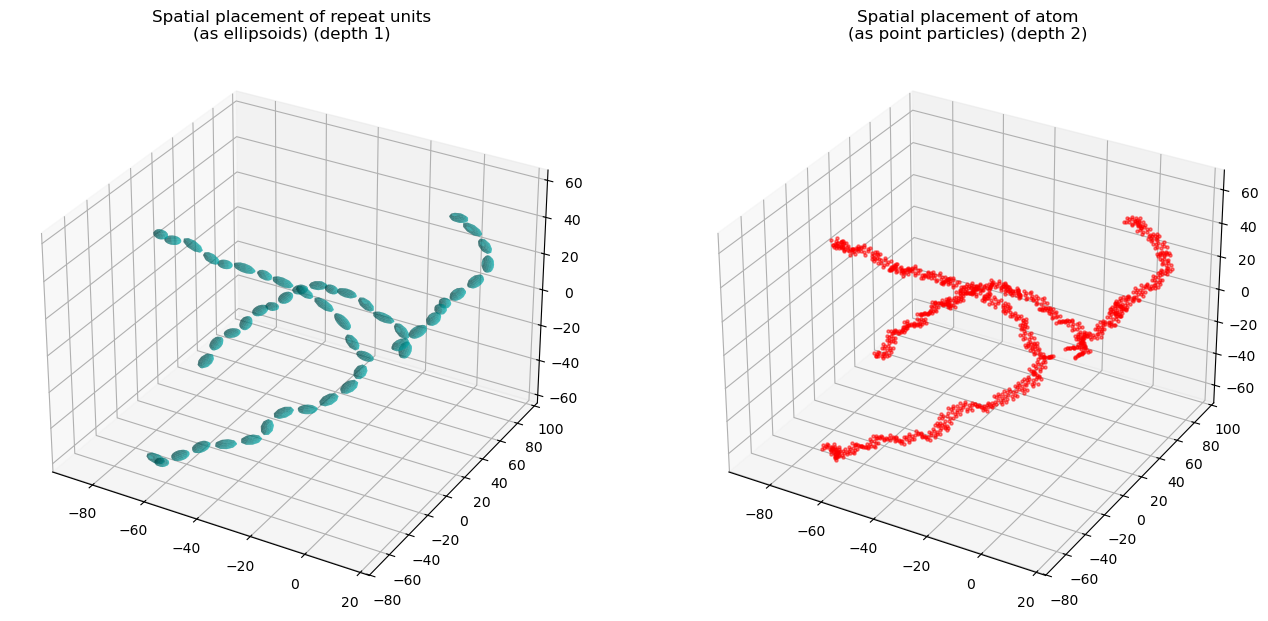

In [8]:
# NBVAL_SKIP
from anytree.iterators import LevelOrderGroupIter

import matplotlib.pyplot as plt
# %matplotlib ipympl

scale : float=16
aspect : float = 1/2
plt.close()
fig = plt.figure(figsize=(scale, scale*aspect))
fig.canvas.header_visible = False

levels : dict[int, tuple[Primitive]] = {i : grp for i, grp in enumerate(LevelOrderGroupIter(univprim))}

ellip_depth : int = 1
ax_ellip = fig.add_subplot(1, 2, ellip_depth, projection='3d')
ax_ellip.autoscale(enable=True)
ax_ellip.set_title(f'Spatial placement of repeat units\n(as ellipsoids) (depth {ellip_depth})')
for res_prim in levels[ellip_depth]:
    _ = ax_ellip.plot_surface(*res_prim.shape.surface_mesh(10, 10).T, color='c', alpha=0.5)

atom_depth : int = 2
ax_atomic = fig.add_subplot(1, 2, atom_depth, projection='3d')
ax_atomic.autoscale(enable=True)
ax_atomic.set_title(f'Spatial placement of atom\n(as point particles) (depth {atom_depth})')
for res_prim in levels[atom_depth]:
    _ = ax_atomic.scatter(*res_prim.shape.positions.T, color='r', marker='.', alpha=0.5)

In [9]:
# from scipy.spatial.transform import Rotation, RigidTransform

# # optional; can apply a rigid transformation to the ENTIRE molecule at once - all sub-parts will be "carried along for the ride"
# random_rot = RigidTransform.from_rotation(Rotation.random())
# univprim.rigidly_transform(random_rot)